# DC Motor Simulation

Look at the dynamics_model.pdf for the explanation behind this code.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

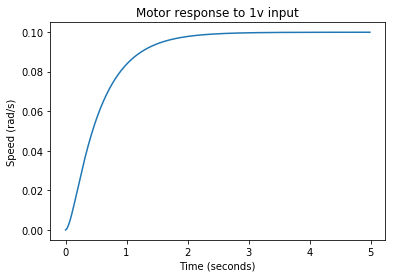

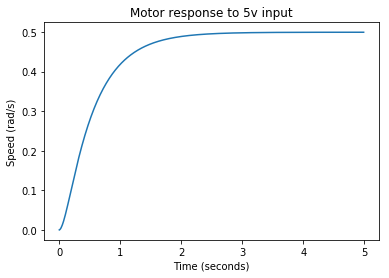

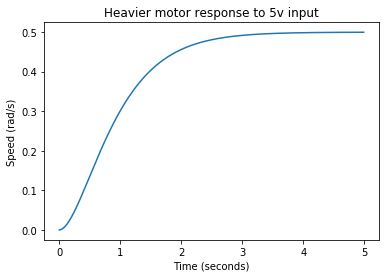

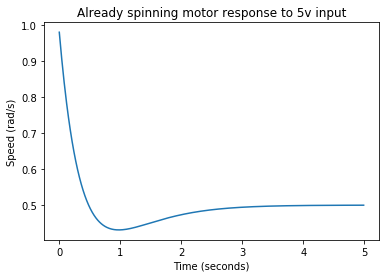

In [3]:
def simulate(V, J, b, K, R, L, theta_dot=0, i=0):
    # simulate T seconds
    T = 5
    dt = 0.01
    ts = np.arange(0, T, dt)
    theta_dots = np.zeros(ts.shape[0])
    currents = np.zeros(ts.shape[0])
    for idx, t in enumerate(ts):
        A = np.array([[-b/J,K/J],[-K/L,-R/L]])
        B = np.array([0, 1/L])
        x = np.array([theta_dot, i])
        w = V(t, i, theta_dot)
        x_dot = A@x+B*w
#         print(x_dot, theta_dot, i)
        theta_dot += (x_dot[0] * dt)
        i += (x_dot[1] * dt)
        theta_dots[idx] = theta_dot
        currents[idx] = i
    
    return ts, theta_dots, currents

def const_V(v):
    def _v(t, i, theta_dot):
        return v
    return _v

ts, theta_dots, _ = simulate(const_V(1), J=0.01, b=0.1, K=0.01, R=1, L=0.5)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Motor response to 1v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

ts, theta_dots, _ = simulate(const_V(5), J=0.01, b=0.1, K=0.01, R=1, L=0.5)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Motor response to 5v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

ts, theta_dots, _ = simulate(const_V(5), J=0.05, b=0.1, K=0.01, R=1, L=0.5)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Heavier motor response to 5v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

ts, theta_dots, _ = simulate(const_V(5), J=0.05, b=0.1, K=0.01, R=1, L=0.5, theta_dot=1)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Already spinning motor response to 5v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

plt.show()

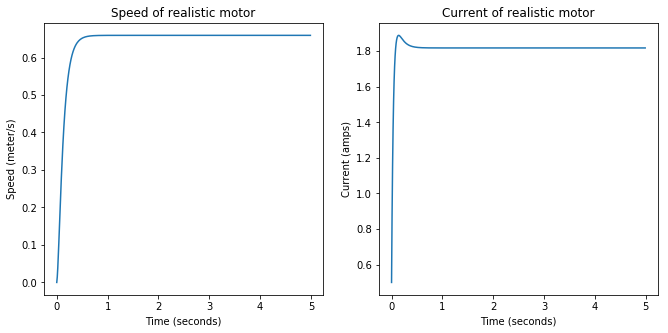

In [4]:
ts, theta_dots, currents = simulate(const_V(5), J=0.00005, b=0.0004, K=0.01, R=2.5, L=0.1)

plt.figure(figsize=(11,5))
plt.subplot(121)
plt.plot(ts, theta_dots * 0.0145)
plt.title("Speed of realistic motor")
plt.ylabel("Speed (meter/s)")
plt.xlabel("Time (seconds)")

plt.subplot(122)
plt.plot(ts, currents)
plt.title("Current of realistic motor")
plt.ylabel("Current (amps)")
plt.xlabel("Time (seconds)")
plt.show()

slope: 0.13182, intercept: 0.00000


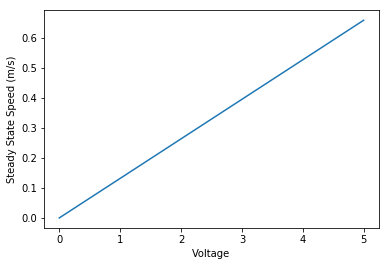

In [26]:
speeds = []
voltages = np.linspace(0, 5, 255)
for v in voltages:
    def vfunc(*args):
        return v
    speed_mps = simulate(vfunc, J=0.00005, b=0.0004, K=0.01, R=2.5, L=0.1)[1][-1] * 0.0145
    speeds.append(speed_mps)
    
m = (speeds[1]-speeds[0])/(voltages[1]-voltages[0])
b = speeds[0]

print("slope: {:0.5f}, intercept: {:0.5f}".format(m, b))

plt.plot(voltages, speeds)
plt.xlabel("Voltage")
plt.ylabel("Steady State Speed (m/s)")
plt.show()

we can use the slope of this line as our feed forward slope
We just need to convert from $\frac{m*s^{-1}}{v}$ to $\frac{f}{rad*s^{-1}}$

$$ \frac{m*s^{-1}}{\text{volts}}*\frac{5\text{ volts}}{255\text{ abstract force}}*\frac{\text{radians}}{0.0145\text{ meters}} $$

The invert this value.

In [30]:
m_ = 1 / (m * 5.0 / 255.0 / 0.0125)
print("ff slope in the correct units is: ", m_)

v = 0.5 / 0.0145
print("To reach 0.5 m/s = {:0.5f} rad/s, our force should be {:0.5f} ".format(v, v * m_))

ff slope in the correct units is:  4.83620689655
To reach 0.5 m/s = 34.48276 rad/s, our force should be 166.76576 
